## Описание проекта
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Считываю файлы и изучаю их

### Импортирую библиотеки

In [23]:
# Импортирую библиотеки
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

### Считываю файлы

In [24]:
# Данные будут храниться в словаре df_dict
files_remote = ['gold_recovery_train_new.csv',
                'gold_recovery_test_new.csv',
                'gold_recovery_full_new.csv']
files_local = ['/datasets/gold_recovery_train_new.csv', 
               '/datasets/gold_recovery_test_new.csv', 
               '/datasets/gold_recovery_full_new.csv']
names = ['train', 'test', 'full']
df_dict = {}
for i in range(len(names)):
    if os.path.exists(files_remote[i]):
        df = pd.read_csv(files_remote[i])
        df_dict['df_' + names[i]] = df
    elif os.path.exists(files_local[i]):
        df = pd.read_csv(files_local[i])
        df_dict['df_' + names[i]] = df
    else:
        print('Something is wrong. Please, check file path.')

### Изучаю данные

In [25]:
# Данные хранятся в df_dict. К df можно обращаться по ключу.
df_dict.keys()

dict_keys(['df_train', 'df_test', 'df_full'])

In [26]:
# Создаю функцию, которая выдает info о df
def get_info(**kwargs):
    for key in kwargs.keys():
        print('\n', key)
        kwargs[key].info()

# Создаю функцию, которая выводит размер df
def get_shape(**kwargs):
    for key in kwargs.keys():
        print(key, 'size:', f'{kwargs[key].shape}')

In [27]:
# Вызов функции
get_info(**df_dict)


 df_train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-nul

In [28]:
# Вызов функции
get_shape(**df_dict)

df_train size: (14149, 87)
df_test size: (5290, 53)
df_full size: (19439, 87)


Вывод.  
Размерность df_train, df_test, df_full отличаются - количество признаков 87 против 53. Все столбцы принадлежат типу float64, кроме столбца date. Столбец date в будущем будет удален. Также есть проущенные значения, но их доля мала. На следующих этапах посмотрю как решать эти проблемы.

### Проверка правильности расчета эффективности обогащения

Порядок действий:  
1) Расчет Recovery вручную  
2) Расчет MAE между полученными пунктом 1) и rougher.output.recovery из df_train

In [29]:
# Функция для расчета Recovery вручную
def recovery(C, F, T):
    return 100 * ((C * (F-T)) / (F * (C-T)))

In [30]:
# Вызов функции Recovery
C = df_dict['df_train']['rougher.output.concentrate_au']
F = df_dict['df_train']['rougher.input.feed_au']
T = df_dict['df_train']['rougher.output.tail_au']
    
target = df_dict['df_train']['rougher.output.recovery']  # Изначальные данные в таблице
predicted = recovery(C, F, T)                            # Вызов функции (подсчет вручную)

# Расчет MAE
mae = mean_absolute_error(target, predicted)
print('MAE:', mae)

MAE: 9.73512347450521e-15


Вывод.  
Эффективность обогащения была рассчитана верно, потому-что MAE = 9.73e-15.

### Анализ признаков, недоступных в тестовой выборке

In [31]:
# Создаю функцию, которая возвращает элементы в листе 1, которых нет в листе 2
def get_list_diff(list1, list2):
    return np.setdiff1d(list1, list2)

In [32]:
# Вызываю функцию
list1 = df_dict['df_train'].columns.to_list() 
list2 = df_dict['df_test'].columns.to_list()

target_leakage_list = get_list_diff(list1, list2)

print(f'Признаки, недоступные в тестовой выборке: \n\n {pd.Series(target_leakage_list)}')

Признаки, недоступные в тестовой выборке: 

 0           final.output.concentrate_ag
1           final.output.concentrate_au
2           final.output.concentrate_pb
3          final.output.concentrate_sol
4                 final.output.recovery
                    ...                
29              rougher.output.tail_sol
30     secondary_cleaner.output.tail_ag
31     secondary_cleaner.output.tail_au
32     secondary_cleaner.output.tail_pb
33    secondary_cleaner.output.tail_sol
Length: 34, dtype: object


Вывод.  
Отсутствуют следующие признаки: final.output, primary_cleaner.output, rougher.calculation, rougher.output, secondary_cleaner.output. Данные признаки относятся к 'утечкам целевого признака', посколько в названиях есть 'output'. Их использовать для построения модели нельзя.

### Предобработка данных

#### Заполняю NaN методом ffill(), поскольку соседние по времени параметры часто похожи (по условию задачи)

In [33]:
# Заполняю методом ffill()
df_dict['df_full'].ffill(axis=0, inplace=True)
df_dict['df_train'].ffill(axis=0, inplace=True)
# Удаляю строки с NaN, поскольку их мало и заполнять ffill() их не следует, потому-что эти строки были взяты из общей выборки
df_dict['df_test'].dropna(inplace=True)

#### Добавляю два недостяющих целевых признака в тестовую выборку: 'rougher.output.recovery' и 'final.output.recovery'

In [34]:
df_dict['df_test'] = pd.merge(df_dict['df_test'], 
                              df_dict['df_full'][['date', 'rougher.output.recovery', 'final.output.recovery']], 
                              on='date', 
                              how='left')

#### Удаляю признаки из обучающей выборки, которые не представлены в тестовой

In [35]:
# Удаляю признаки из обучающей выборки, которые не представлены в тестовой 
df_dict['df_train'] = df_dict['df_train'][df_dict['df_test'].columns]

In [36]:
# Проверяю
get_shape(**df_dict)

df_train size: (14149, 55)
df_test size: (5229, 55)
df_full size: (19439, 87)


Вывод.  
Пробелы были заполнены методом ffill(), поскольку соседние по времени параметры часто похожи по условию задачи. В тестовой выборке пробелы были удалены. Два недостающих целевых признака были добавлены в тестовую выборку. Из обучающей выборки были удалены целевые признаки утечки. Теперь в обучяющей и тестовой выборках одинаковые количество признаков - 55 (включая признак date).

## Анализ данных

### Как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

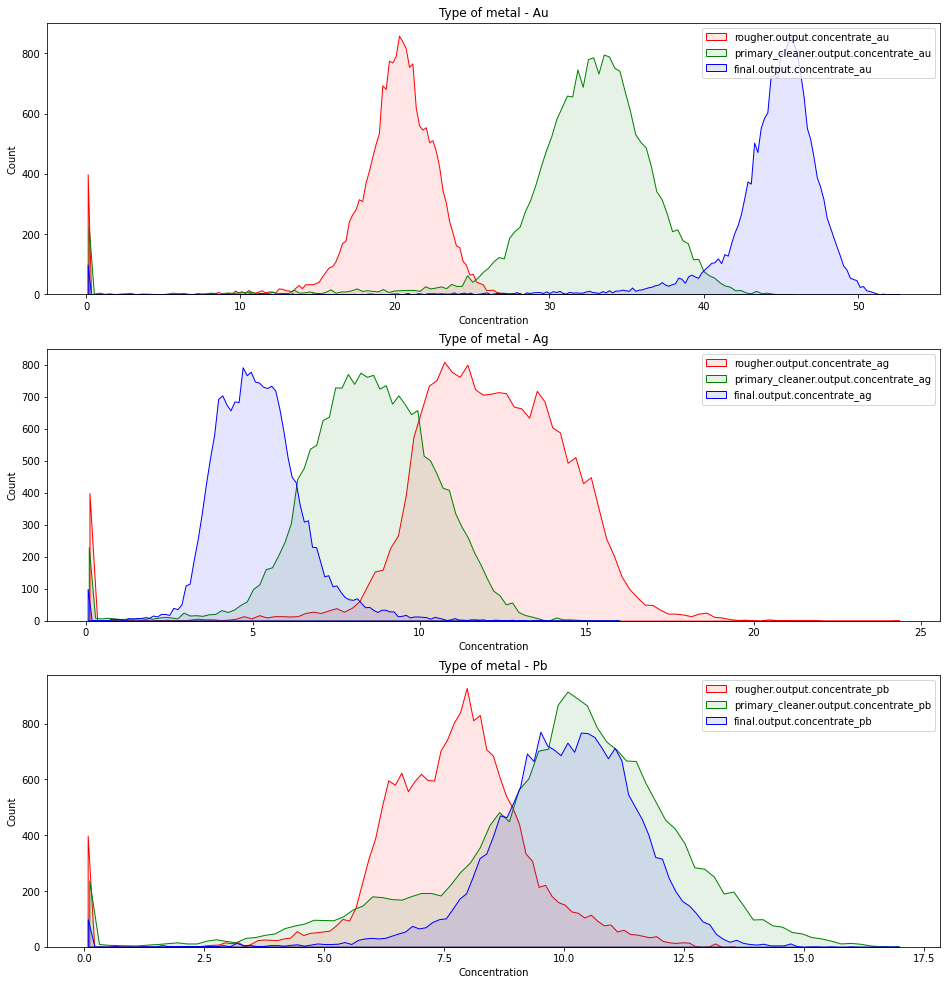

In [37]:
metals = ['Au', 'Ag', 'Pb']
stages = ['rougher.output.concentrate_', 'primary_cleaner.output.concentrate_', 'final.output.concentrate_']
colors = ['red', 'green', 'blue']

fig, ax = plt.subplots(3, 1, figsize=(16, 17))

for i, metal in enumerate(metals):
    for j, stage in enumerate(stages):    
        sns.histplot(df_dict['df_full'], 
                     x=stage + metal.lower(), 
                     fill=True, 
                     ax=ax[i], 
                     label=stage + metal.lower(),
                     color=colors[j],
                     alpha=0.1,
                     element='poly')
        ax[i].legend()
        ax[i].set_title(f'Type of metal - {metal}')
        
    ax[i].set_xlabel('Concentration')

plt.show()

Вывод.  
Концентрация золота (Au) растет на каждом последующем этапе очистки. Концентрация серебра (Ag) на каждом последующем этапе растет. Концентрация свинца (Pb) варьируется в зависимости от этапа. На каждом этапе есть выбросы в нулевых значениях.

### Сравните распределения размеров гранул сырья на обучающей и тестовой выборках

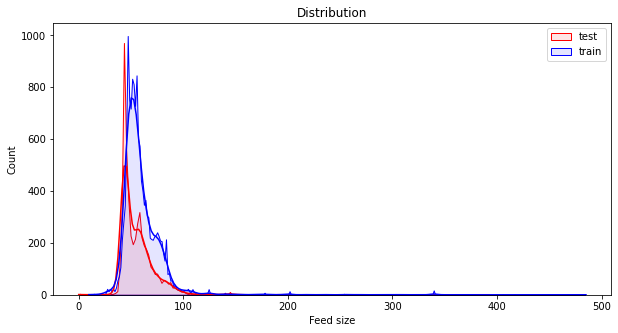

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(df_dict['df_test'], x='rougher.input.feed_size', 
             fill=True, element='poly', label='test', color='red', kde=True, alpha=0.1, ax=ax)
sns.histplot(df_dict['df_train'], x='rougher.input.feed_size', 
             fill=True, element='poly', label='train', color='blue', kde=True, alpha=0.1, ax=ax)
plt.title('Distribution')
plt.xlabel('Feed size')
plt.legend()
plt.show()

Вывод.  
Распределение размеров гранул сырья на обучающей и тестовой выборках почти одинаковое, значит оценка модели будет правильной.

### Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

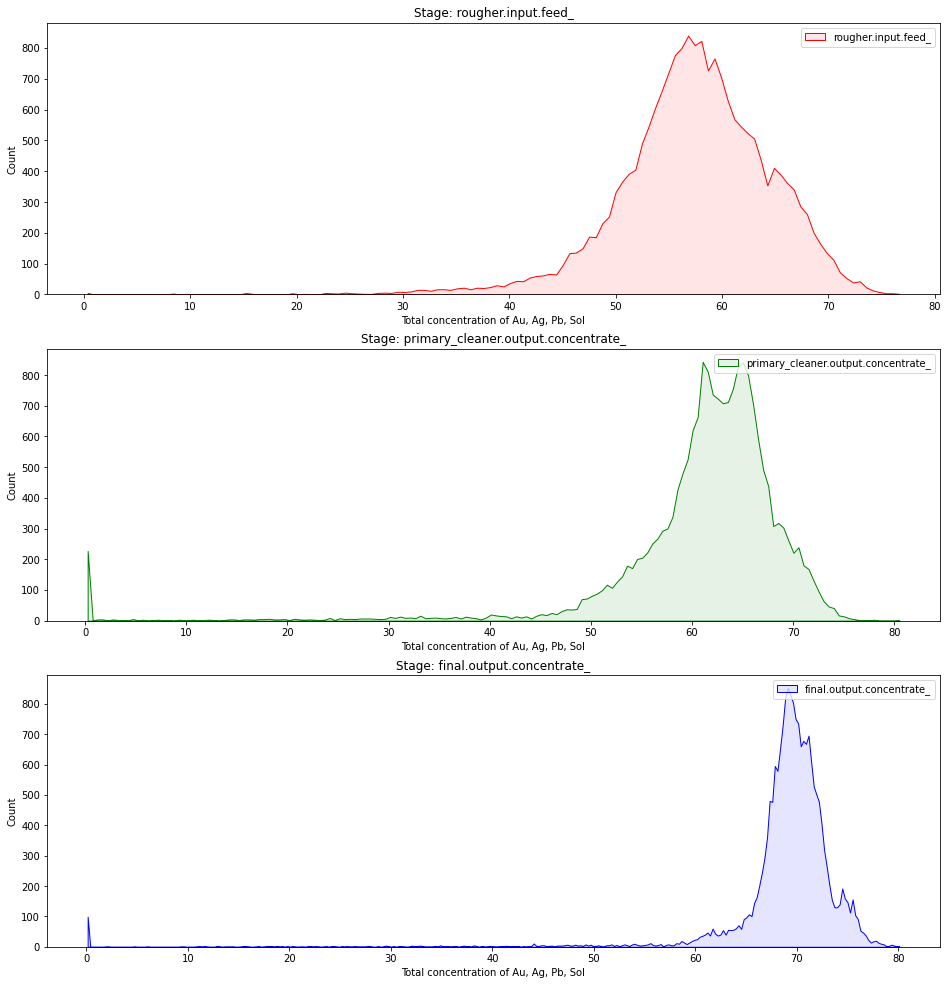

In [39]:
metals = ['Au', 'Ag', 'Pb', 'Sol']
stages = ['rougher.input.feed_', 'primary_cleaner.output.concentrate_', 'final.output.concentrate_']
colors = ['red', 'green', 'blue']

fig, ax = plt.subplots(3, 1, figsize=(16, 17))

for i, stage in enumerate(stages): 
    total_concentration_stage = 0
    
    for j, metal in enumerate(metals): 
        total_concentration_stage += df_dict['df_full'][stage + metal.lower()]
        
    sns.histplot(total_concentration_stage, 
                 fill=True, 
                 ax=ax[i], 
                 label=stage,
                 color=colors[i],
                 alpha=0.1,
                 element='poly')
    ax[i].legend()
    ax[i].set_title('Stage: ' + stage)    
    ax[i].set_xlabel('Total concentration of Au, Ag, Pb, Sol')

plt.show()

Вывод.  
Есть аномалии в нуле, т.к. суммарная концентрация веществ нулем быть не может. Думаю, что стоит удалить аномалии из всех выборок, т.к. будущая может быть чувствительна чувствительна к нулевым значениям.

### Удаление аномалий из основной выборки

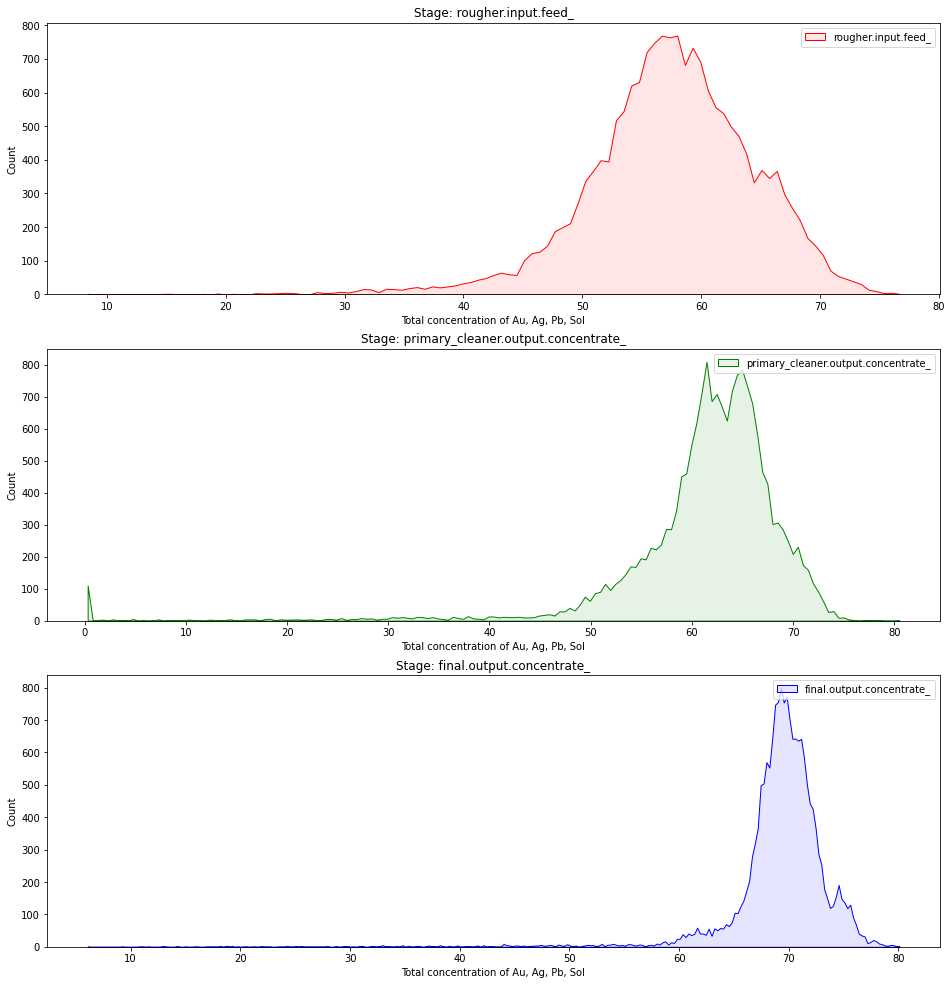

In [40]:
# Заменяю нули на NaN
df_dict['df_full'] = df_dict['df_full'].replace(0, np.nan)
# Удаляю NaN
df_dict['df_full'] = df_dict['df_full'].dropna(how='any', axis=0)

# Строю графики повторно
metals = ['Au', 'Ag', 'Pb', 'Sol']
stages = ['rougher.input.feed_', 'primary_cleaner.output.concentrate_', 'final.output.concentrate_']
colors = ['red', 'green', 'blue']

fig, ax = plt.subplots(3, 1, figsize=(16, 17))

for i, stage in enumerate(stages): 
    total_concentration_stage = 0
    
    for j, metal in enumerate(metals): 
        total_concentration_stage += df_dict['df_full'][stage + metal.lower()]
        
    sns.histplot(total_concentration_stage, 
                 fill=True, 
                 ax=ax[i], 
                 label=stage,
                 color=colors[i],
                 alpha=0.1,
                 element='poly')
    ax[i].legend()
    ax[i].set_title('Stage: ' + stage)    
    ax[i].set_xlabel('Total concentration of Au, Ag, Pb, Sol')

plt.show()

Вывод.  
На черновом концентрате остались значения, близкие к нулю, но не нули. В финальном концентрате нулевые значения исчезли.

### Удаление аномалий из тренировочной и тестовой выборок

In [41]:
# Заменяю нули на NaN
df_dict['df_test'] = df_dict['df_test'].replace(0, np.nan)
# Удаляю NaN
df_dict['df_test'] = df_dict['df_test'].dropna(how='any', axis=0)
# Заменяю нули на NaN
df_dict['df_train'] = df_dict['df_train'].replace(0, np.nan)
# Удаляю NaN
df_dict['df_train'] = df_dict['df_train'].dropna(how='any', axis=0)

In [42]:
get_shape(**df_dict)

df_train size: (13769, 55)
df_test size: (5105, 55)
df_full size: (17779, 87)


Вывод.  
Аномалии и NaN были удалены из тестовой и тренировочной выборок.

## Функция sMAPE

In [43]:
def smape(y_target, y_pred):
    return ((1/len(y_target)) * np.sum(2 * np.abs(y_target - y_pred) / 
                                       (np.abs(y_target) + np.abs(y_pred)))) * 100

In [44]:
# Создаю scorer, который передам в GridSearchCV
smape_score = make_scorer(smape, greater_is_better=False)

## Построение моделей

In [45]:
# Присваиваю df в отдельные переменные для удобства
df_train = df_dict['df_train']
df_test = df_dict['df_test']

In [46]:
# Удаляю столбец date
df_train.drop('date', axis=1, inplace=True)
df_test.drop('date', axis=1, inplace=True)

In [47]:
# Проверяю размерность
print(df_test.shape)
print(df_train.shape)

(5105, 54)
(13769, 54)


### Целевой признак rougher.output.recovery

In [48]:
X_rougher_train = df_train.drop(columns=['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_rougher_train = df_train['rougher.output.recovery']

X_rougher_test = df_test.drop(columns=['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_rougher_test = df_test['rougher.output.recovery']

In [49]:
# LinearRegression()
model = LinearRegression()
# Результат методом кросс-валидации
scores = cross_val_score(model, X_rougher_train, y_rougher_train, scoring=smape_score, cv=5)
scores

array([-9.44918852, -7.03627165, -5.58192571, -4.86931517, -9.07306626])

In [50]:
final_score = sum(scores)/len(scores)
final_score

-7.201953460972161

In [51]:
model.fit(X_rougher_train, y_rougher_train)
predicted = model.predict(X_rougher_test)
mse = mean_squared_error(y_rougher_test, predicted)
rmse = mse**0.5
rmse

5.345407888804854

In [52]:
# RandomForestRegressor()
model = RandomForestRegressor(random_state=0, max_depth=5, n_estimators=100)
# Результат методом кросс-валидации
scores = cross_val_score(model, X_rougher_train, y_rougher_train, scoring=smape_score, cv=5)
scores

array([-8.65090924, -6.8009756 , -4.72479407, -4.94877415, -7.43341527])

In [53]:
final_score = sum(scores)/len(scores)
final_score

-6.511773664553893

In [54]:
model.fit(X_rougher_train, y_rougher_train)
predicted = model.predict(X_rougher_test)
mse = mean_squared_error(y_rougher_test, predicted)
rmse = mse**0.5
rmse

5.20753754343794

Считаю smape для rougher используя RandomForestRgressor(), т.к. он немного лучше чем LinearRegression().

In [55]:
smape_rougher = smape(y_rougher_test, predicted)
print('sMAPE для rougher: ', smape_rougher)

sMAPE для rougher:  4.5218952422639225


### Целевой признак final.output.recovery

In [56]:
X_final_train = df_train.drop(columns=['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_final_train = df_train['final.output.recovery']

X_final_test = df_test.drop(columns=['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_final_test = df_test['final.output.recovery']

In [57]:
# LinearRegression()
model = LinearRegression()
# Результат методом кросс-валидации
scores = cross_val_score(model, X_final_train, y_final_train, scoring=smape_score, cv=5)
scores

array([-12.94966054,  -9.3054502 ,  -9.4079231 ,  -9.29195711,
       -13.78523206])

In [58]:
final_score = sum(scores)/len(scores)
final_score

-10.948044600179676

In [59]:
model.fit(X_final_train, y_final_train)
predicted = model.predict(X_final_test)
mse = mean_squared_error(y_final_test, predicted)
rmse = mse**0.5
rmse

7.888867985885278

RMSE без кросс-валидации = 7.9

In [60]:
# RandomForestRegressor()
model = RandomForestRegressor(random_state=0, max_depth=5, n_estimators=100)
# Результат методом кросс-валидации
scores = cross_val_score(model, X_final_train, y_final_train, scoring=smape_score, cv=5)
scores

array([ -9.41637549,  -9.64584433,  -8.82255278,  -8.49086171,
       -10.10876032])

In [61]:
final_score = sum(scores)/len(scores)
final_score

-9.29687892604505

In [62]:
model.fit(X_final_train, y_final_train)
predicted = model.predict(X_final_test)
mse = mean_squared_error(y_final_test, predicted)
rmse = mse**0.5
rmse

7.546746096292503

Считаю sMAPE для RandomForestRegressor(), т.к. он лучше считает RMSE, чем LinearRegression().

In [63]:
smape_final = smape(y_final_test, predicted)
print('sMAPE для final: ', smape_final)

sMAPE для final:  8.145932228310517


### Итоговое sMAPE

In [64]:
sMAPE = 0.25 * smape_rougher + 0.75 * smape_final
sMAPE

7.239922981798869

## Вывод

Был посчитан итоговый sMAPE = 7.3